<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part10/P10_CH02_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Localization & 성능개선
- Oxford-IIIT Pet dataset은 37종의 개, 고양이로 구성된 dataset입니다.
- 파일은 하나의 압축파일로 구성되며 압축파일은 다음과 같이 구성되어 있습니다.
- 모든 데이터의 이름은 class_name.(확장자)로 구성되어 있으며 class_name의 첫 알파벳이 대문자이면 '고양이', 소문자이면 '개'입니다.

1. images
  - image 데이터들이 포함되어 있음
  - 확장자는 모두 jpg임
  - RGB이미지 외에도 Gray scale이나 RGBA 이미지도 함께 포함되어 있음
2. annotations/xmls
  - localization을 위한 bounding-box 위치 정보가 포함되어 있음
  - image의 width, height 등 기타 다른 정보도 함께 저장되어 있음
  - 확장자는 모두 xml임
3. annotations/trimaps
  - segmentation을 위한 segmentation map이 포함되어 있음
  - 확장자는 모두 png임
  

- localization / multitask learning 성능향상 방법

# 1. 데이터 다운로드 / 전처리

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import xml.etree.ElementTree as et
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import gdown

In [2]:
data_url = "https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0"

In [3]:
gdown.download(data_url, 'oxford_pet.zip', quiet=False)
!unzip -q oxford_pet.zip -d oxford_pet

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
100%|██████████| 811M/811M [00:09<00:00, 84.6MB/s]


In [4]:
# directory 정보
## image data : images -> jpg -> n_images
## bounding box : annotations/xmls -> xml -> n_bboxes

cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
bbox_dir = os.path.join(data_dir, 'annotations','xmls')

In [5]:
# image file 개수
image_files =[fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] =='.jpg']
n_images = len(image_files)
print(n_images)

7390


In [6]:
# localization을 위한 bounding box 정보가 있는 xml file의 수 확인
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] =='.xml']
n_bboxes = len(bbox_files)
print(n_bboxes)

3686


- head ROI가 있는 이미지가 3686개밖에 없으므로 이미지도 3686개만 사용

## 데이터 확인하기
- bounding boxsms matplotlib.patches 의 Rectangle 이용
- 좌측 상단좌표 (x,y) -> rect_x, rect_y
- width, height -> rect_w, rect_h


<ipython-input-10-d1b47114f7e2>:8: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './object/bndbox/xmin'
  xmin = float(tree.find('/object/bndbox/xmin').text)
<ipython-input-10-d1b47114f7e2>:9: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './object/bndbox/ymin'
  ymin = float(tree.find('/object/bndbox/ymin').text)
<ipython-input-10-d1b47114f7e2>:10: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './object/bndbox/xmax'
  xmax = float(tree.find('/object/bndbox/xmax').text)
<ipython-input-10-d1b47114f7e2>:11: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './object/bndbox/ymax'
  ymax = flo

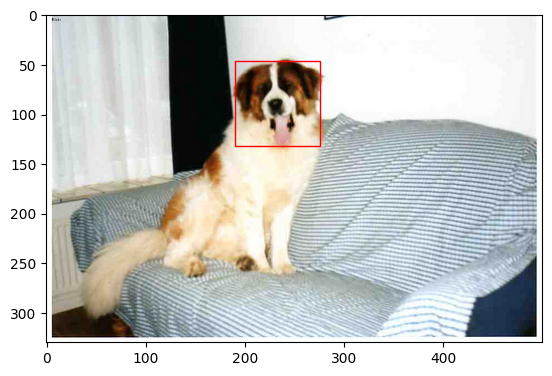

In [10]:
rnd_idx = random.randint(0, n_bboxes-1)

bbox_name = bbox_files[rnd_idx]
bbox_path = os.path.join(bbox_dir, bbox_name)

tree = et.parse(bbox_path)

xmin = float(tree.find('/object/bndbox/xmin').text)
ymin = float(tree.find('/object/bndbox/ymin').text)
xmax = float(tree.find('/object/bndbox/xmax').text)
ymax = float(tree.find('/object/bndbox/ymax').text)


rect_x = xmin
rect_y = ymin
rect_w = xmax - xmin
rect_h = ymax - ymin


# Abyssinian_1.xml -> Abyssinisan_1.jpg
fname = os.path.splitext(bbox_name)[0] + '.jpg'

fpath = os.path.join(image_dir, fname)
image = Image.open(fpath)
image = np.array(image)

rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill = False, color = 'red')
plt.axes().add_patch(rect)
plt.imshow(image)
plt.show()

## RGB외의 data 삭제
- RGB 아닌 image, bounding box file 삭제
- PIL.Image mode 사용

In [12]:
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    bbox_file = os.path.splitext(image_file)[0] + '.xml'
    bbox_path = os.path.join(bbox_dir, bbox_file)
    image = Image.open(image_path)

    if image.mode != 'RGB':
        print(image_file, image.mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(image_path)
        try :
            os.remove(bbox_path)
        except FileNotFoundError:
            pass

Egyptian_Mau_145.jpg P
(188, 216)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
Abyssinian_5.jpg RGBA
(150, 200, 4)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_177.jpg P
(175, 246)
Abyssinian_34.jpg P
(202, 250)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Egyptian_Mau_167.jpg P
(275, 183)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_139.jpg P
(250, 350)


In [13]:
# image file 개수
image_files =[fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] =='.jpg']
n_images = len(image_files)
print(n_images)


7378


In [14]:
#bbox_files 개수
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] =='.xml']
n_bboxes = len(bbox_files)
print(n_bboxes)

3685
